In [80]:
# Import packages
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import date_to_unix as date
import datetime
import itertools
import numpy as np

In [81]:
# Load data
data = pd.read_csv('/Users/nikopindao/Desktop/Master /MA2/Blockchain /Project/Carry_Trade/data/Bitcoin 2019-09-10')
data['Open Time'] = pd.to_datetime(data['Open Time'])  # Convert before setting as index
data.set_index('Open Time', inplace=True, drop=True)
data

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate
Open Time,,,,,
2019-09-10 08:00:00,10272.64,10271.93,0.000100,NaN,0.000100
2019-09-10 16:00:00,10176.26,10172.13,0.000100,NaN,0.000200
2019-09-11 00:00:00,10098.19,10094.27,0.000100,NaN,0.000300
2019-09-11 08:00:00,10066.38,10068.41,0.000100,NaN,0.000400
2019-09-11 16:00:00,9990.57,9992.18,0.000100,NaN,0.000500
...,...,...,...,...,...
2024-05-14 00:00:00,62940.09,62912.20,0.000099,62917.600000,0.688804
2024-05-14 08:00:00,62035.39,62002.00,0.000100,62003.151865,0.688904
2024-05-14 16:00:00,61787.60,61750.00,0.000044,61749.900000,0.688948


In [82]:
def Strategy(data, X, fees_future, fees_spot, threshold):
    # Initial fraction of BTCUSDT held as perp and spot
    fract_perp = (X / data['Open BTCUSDT_PERP'][0])
    fract_spot = (X / data['Open BTCUSDT_SPOT'][0])

    # Compute initial fees from the first position and substract later to the first result
    initial_fees = -(X * fees_future + X * fees_spot)

    # Initialize variables
    position_open = True
    last_open_index = 0
    result = []
    PandL = []
    size_final_f = []
    size_final_s = []

    # Iterate through the data
    for i in range(len(data)):

        if position_open:

            if data['fundingRate'].iloc[i] < 0 and abs(data['fundingRate'].iloc[i] * fract_perp) > threshold:
                # Close the position
                position_open = False
                # Compute the fees for closing the position
                result.append(-(X * fees_future + X * fees_spot))
                # Compute the P&L for closing the position
                PandL.append((fract_perp * (- data['Open BTCUSDT_PERP'].iloc[i] + data['Open BTCUSDT_PERP'].iloc[last_open_index])) +
                             (fract_spot * (data['Open BTCUSDT_SPOT'].iloc[i] - data['Open BTCUSDT_SPOT'].iloc[last_open_index])))
                X += ((PandL[-1] + sum(result[last_open_index:i]))/2)
                size_final_f.append(0)
                size_final_s.append(0)

            else:
                # Keep the position open
                position_open = True
                result.append(X * data['fundingRate'].iloc[i])
                PandL.append((fract_perp * (- data['Open BTCUSDT_PERP'].iloc[i] + data['Open BTCUSDT_PERP'].iloc[last_open_index])) +
                             (fract_spot * (data['Open BTCUSDT_SPOT'].iloc[i] - data['Open BTCUSDT_SPOT'].iloc[last_open_index])))
                size_final_f.append(fract_perp * data['Open BTCUSDT_PERP'].iloc[i])
                size_final_s.append(fract_spot * data['Open BTCUSDT_SPOT'].iloc[i])

        else: # If position is closed

            # Check if condition still holds
            if data['fundingRate'].iloc[i] < 0 and abs(data['fundingRate'].iloc[i] * fract_perp) > threshold:
                # Keep position closed  
                position_open = False
                result.append(0)
                PandL.append(0)
                size_final_f.append(0)
                size_final_s.append(0)

            else:
                # Reopen position 
                position_open = True 
                last_open_index = i
                fract_perp = (X / data['Open BTCUSDT_PERP'].iloc[i])
                fract_spot = (X / data['Open BTCUSDT_SPOT'].iloc[i])
                size_final_f.append(fract_perp * data['Open BTCUSDT_PERP'].iloc[i])
                size_final_s.append(fract_spot * data['Open BTCUSDT_SPOT'].iloc[i])
                PandL.append(0)
                result.append((X * data['fundingRate'].iloc[i]) - (X * fees_future + X * fees_spot))

    result[0] += initial_fees

    # Compute the cumulative sum
    cumulative_sum = list(itertools.accumulate(result))

    return cumulative_sum, result, PandL, size_final_f, size_final_s

In [83]:
def compute_returns(data, cumulative_sum, PandL, size_final_s, size_final_f, fees_spot, fees_future):
    size_final_s_multiplied = [i * fees_spot for i in size_final_s]
    size_final_f_multiplied = [i * fees_future for i in size_final_f]

    returns = []
    for i in range(len(cumulative_sum)):
        result = cumulative_sum[i] + PandL[i] - size_final_s_multiplied[i] - size_final_f_multiplied[i]
        returns.append(result)

    data['strat_returns'] = returns
    data['PandL'] = PandL

    return data

In [84]:
def plot_data(data_hold):
    plt.figure(figsize=(10, 5))  
    plt.plot(data_hold.index, data_hold['PandL'], label='P&L')
    plt.title('P&L') 
    plt.ylabel('P&L')
    plt.xlabel('Date')
    plt.grid(True) 
    plt.legend() 
    plt.show() 

    plt.figure(figsize=(10, 5))  
    plt.plot(data_hold.index, data_hold['strat_returns'], label='Returns Hold strategy')
    plt.title('Hold strategy') 
    plt.ylabel('Cumulative Sum')
    plt.xlabel('Date')
    plt.grid(True)  
    plt.legend() 
    plt.show() 

In [85]:
def plot_data_side_by_side(data_hold, data_threshold):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))  

    # Plot P&L for data_hold
    axs[0, 0].plot(data_hold.index, data_hold['PandL'], label='P&L Hold')
    axs[0, 0].set_title('P&L Hold')
    axs[0, 0].set_ylabel('P&L')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Plot P&L for data_threshold
    axs[0, 1].plot(data_threshold.index, data_threshold['PandL'], label='P&L Threshold')
    axs[0, 1].set_title('P&L Threshold')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot strat_returns for data_hold
    axs[1, 0].plot(data_hold.index, data_hold['strat_returns'], label='Returns Hold strategy')
    axs[1, 0].set_title('Hold strategy')
    axs[1, 0].set_ylabel('Returns')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Plot strat_returns for data_threshold
    axs[1, 1].plot(data_threshold.index, data_threshold['strat_returns'], label='Returns Threshold strategy')
    axs[1, 1].set_title('Threshold strategy')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    # Display the plot
    plt.show()

### Holding startegy 

In [86]:
fees_spot = 0.0001
fees_future = 0.0001
X=10000

In [87]:
cumulative_sum_hold, result_hold, PandL_hold, size_final_f_hold, size_final_s_hold = Strategy(data, X, fees_future, fees_spot, float('inf'))

In [88]:
data_hold = data.copy()
data_hold = compute_returns(data_hold, cumulative_sum_hold, PandL_hold, size_final_s_hold, size_final_f_hold, fees_spot, fees_future)

### Threshold strategy 

In [89]:
fees_spot = 0.0001
fees_future = 0.0001
X=10000

In [90]:
# Create list with several threshold to find out if there is an optimal threshold

# Thresholds to test, once plotted we see that the optimal threshold is between 0 and 0.0002
# thresholds = np.linspace(-0.0005, 0.0005, 10).tolist()

# Second threshold test
thresholds =  np.linspace(0., 0.0002, 10).tolist()


data_thresholds = []

for threshold in thresholds:
    cumulative_sum, result, PandL, size_final_f, size_final_s = Strategy(data, X, fees_future, fees_spot, threshold)
    data_threshold = data.copy()
    data_threshold = compute_returns(data_threshold, cumulative_sum, PandL, size_final_s, size_final_f, fees_spot, fees_future)
    data_thresholds.append(data_threshold)

### Results

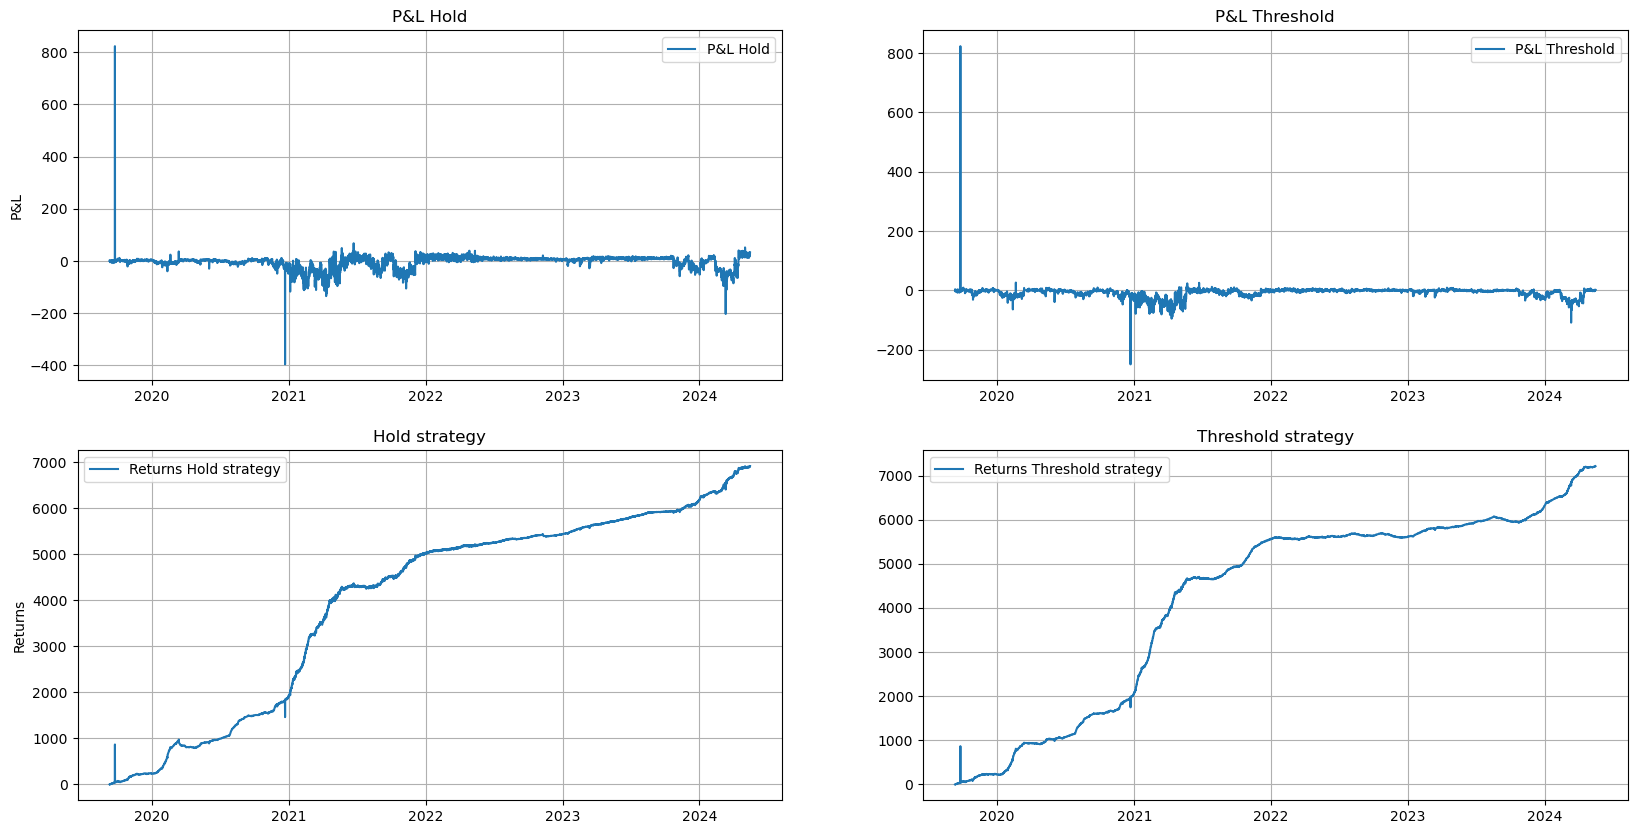

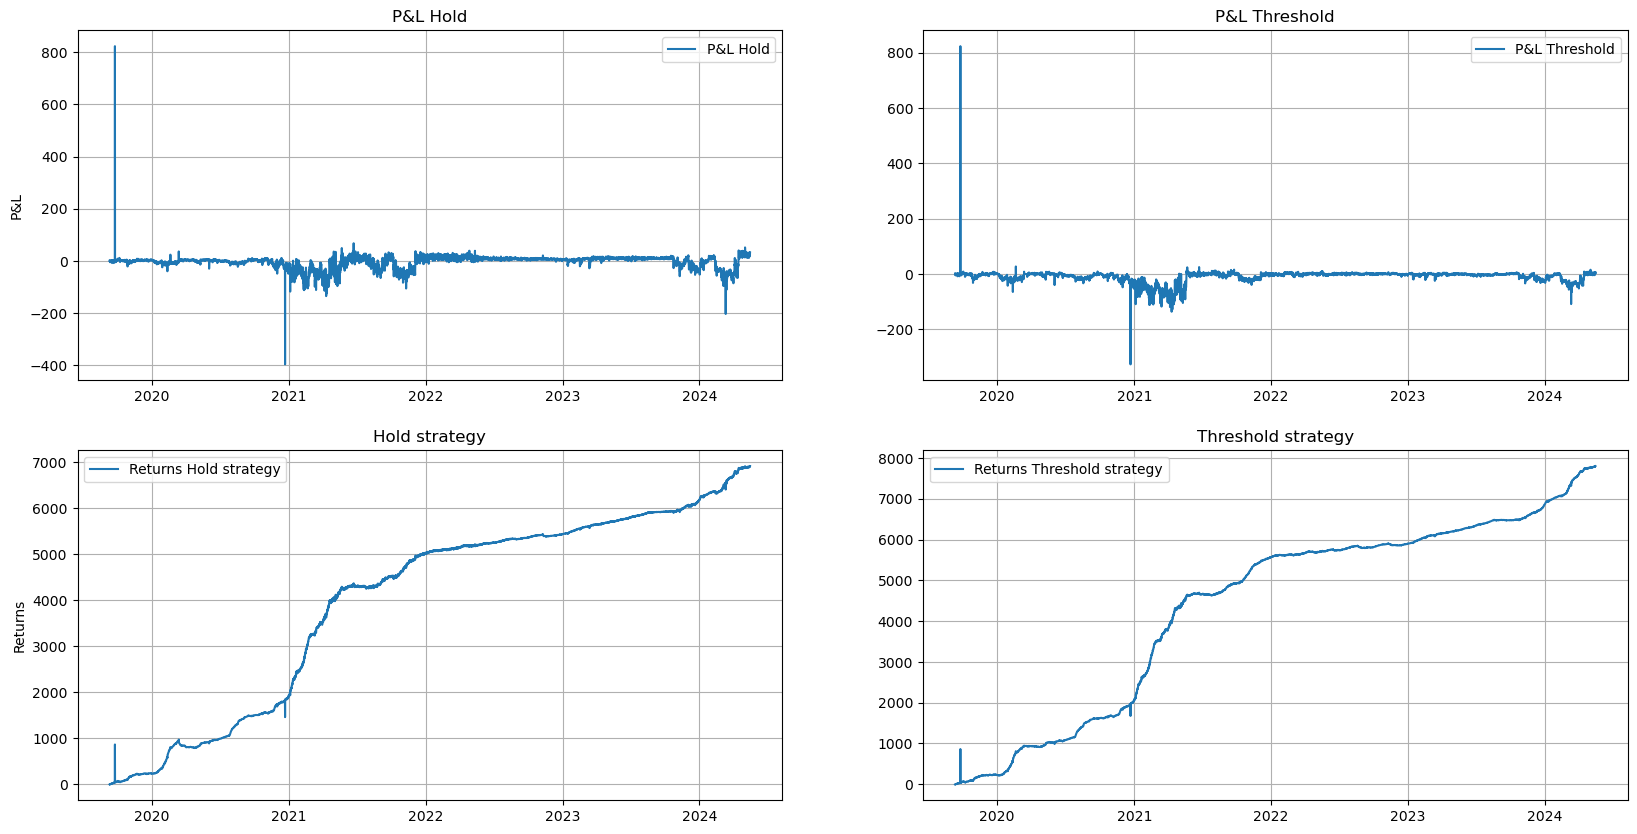

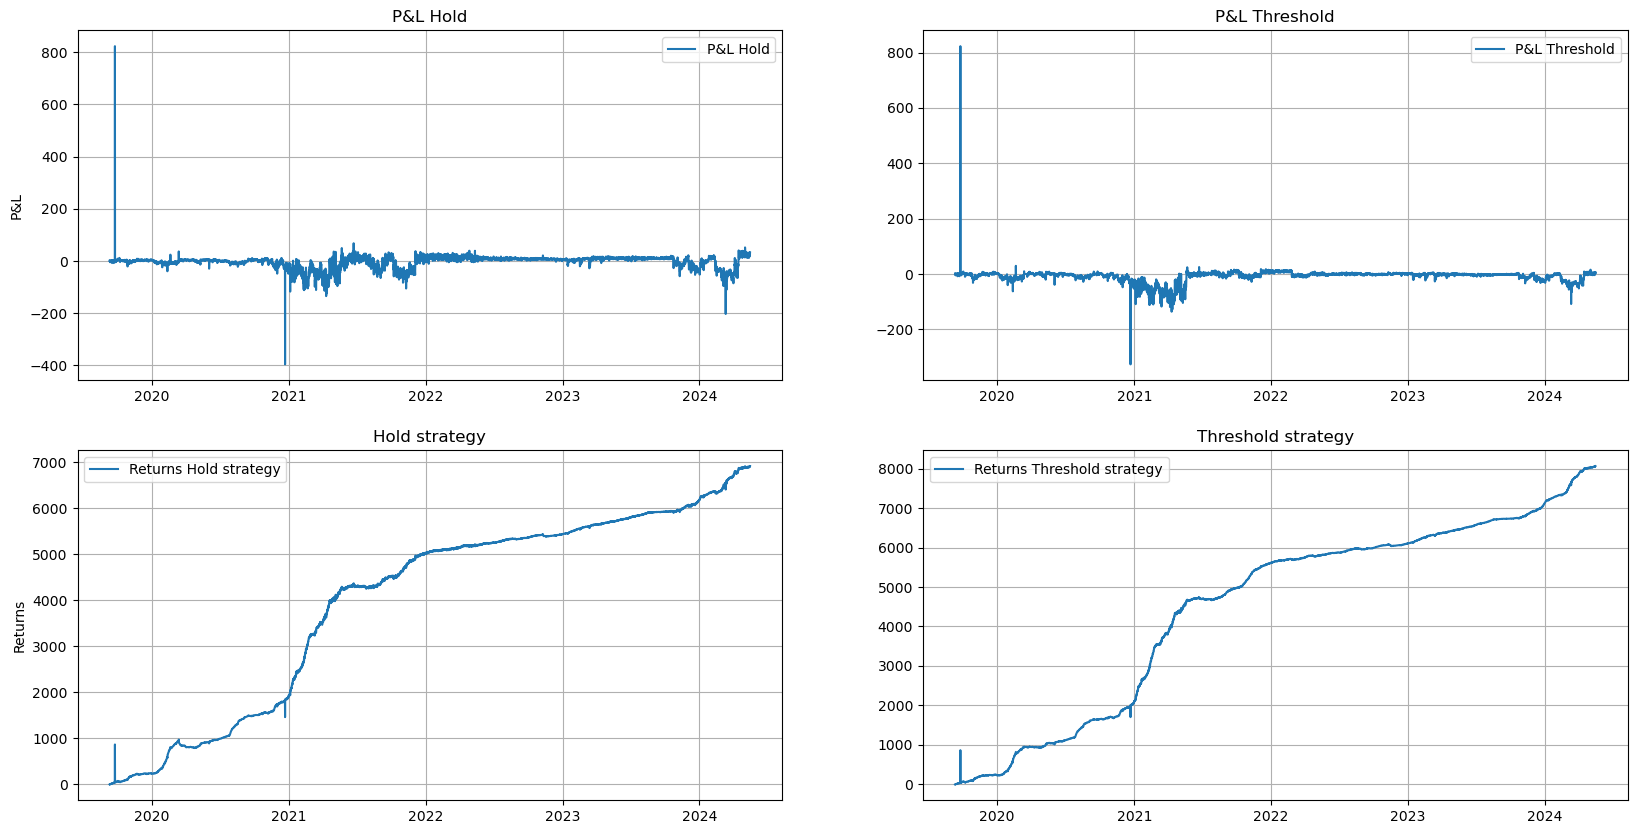

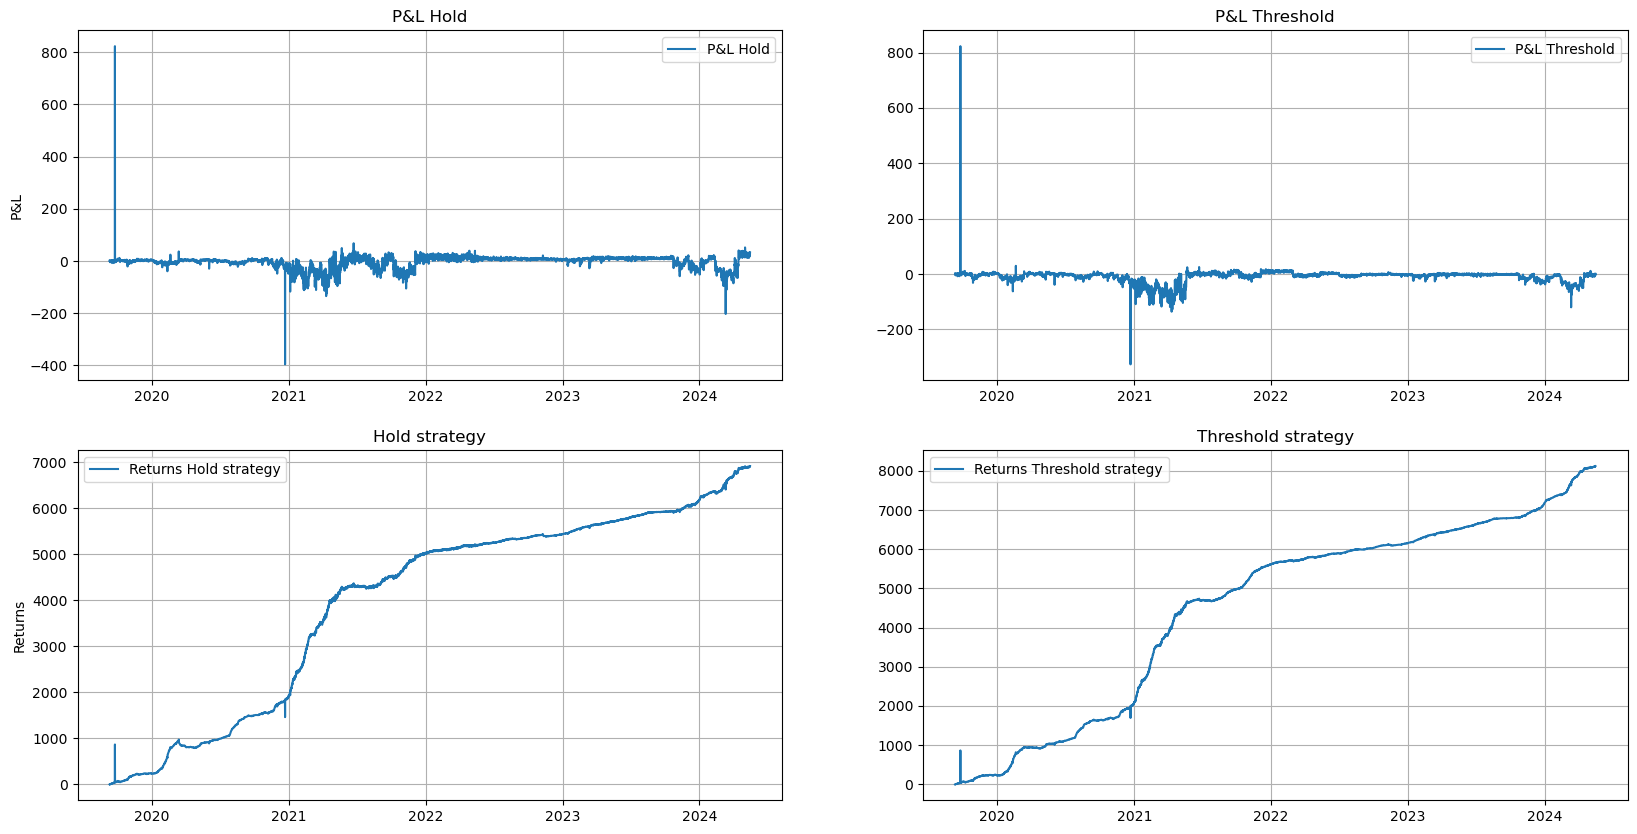

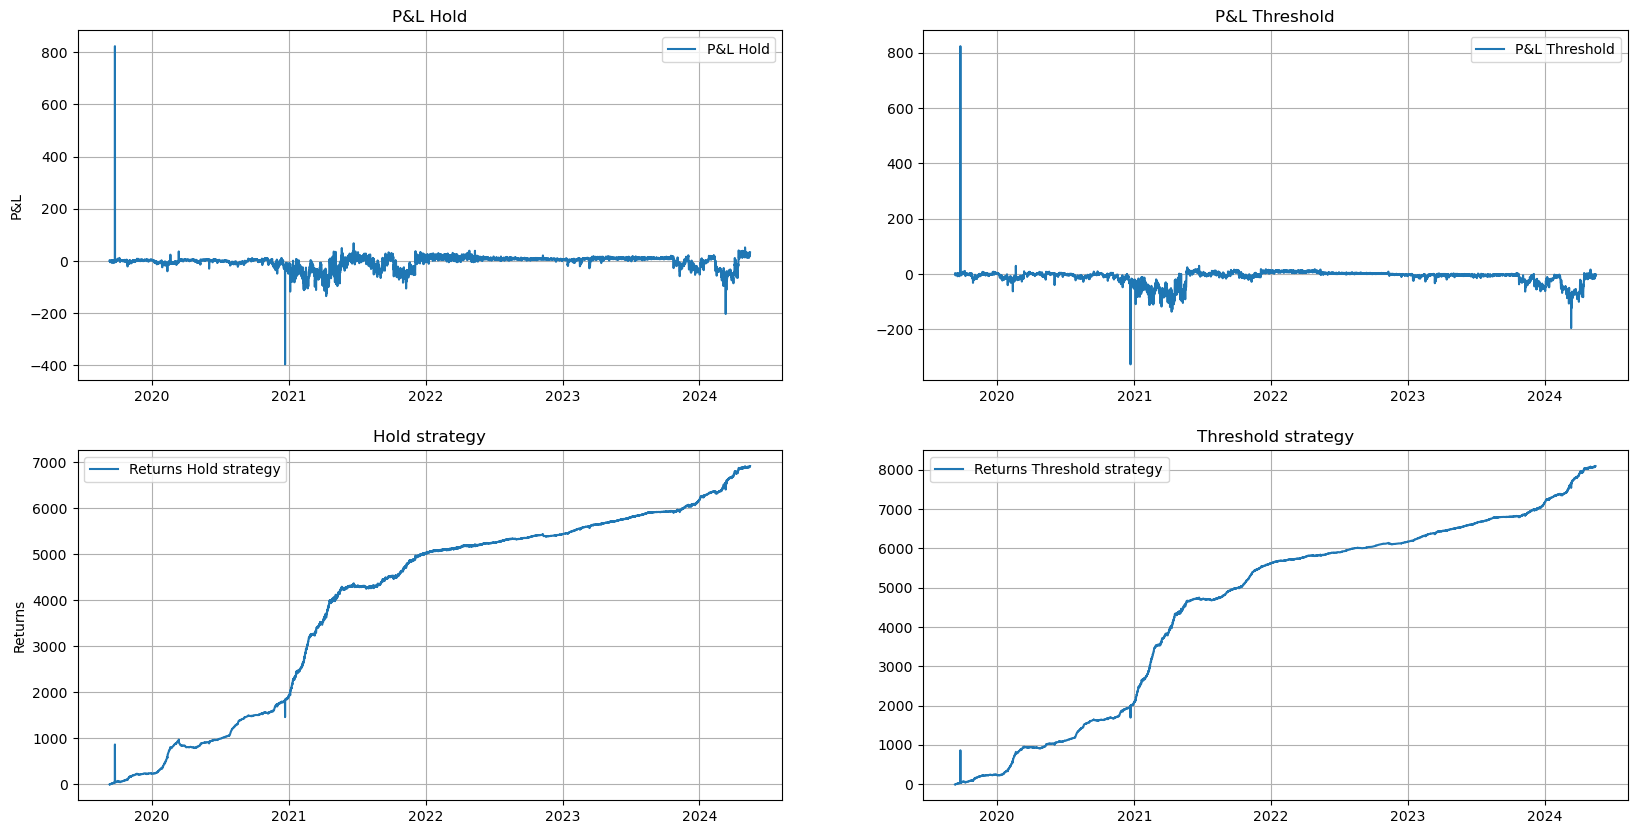

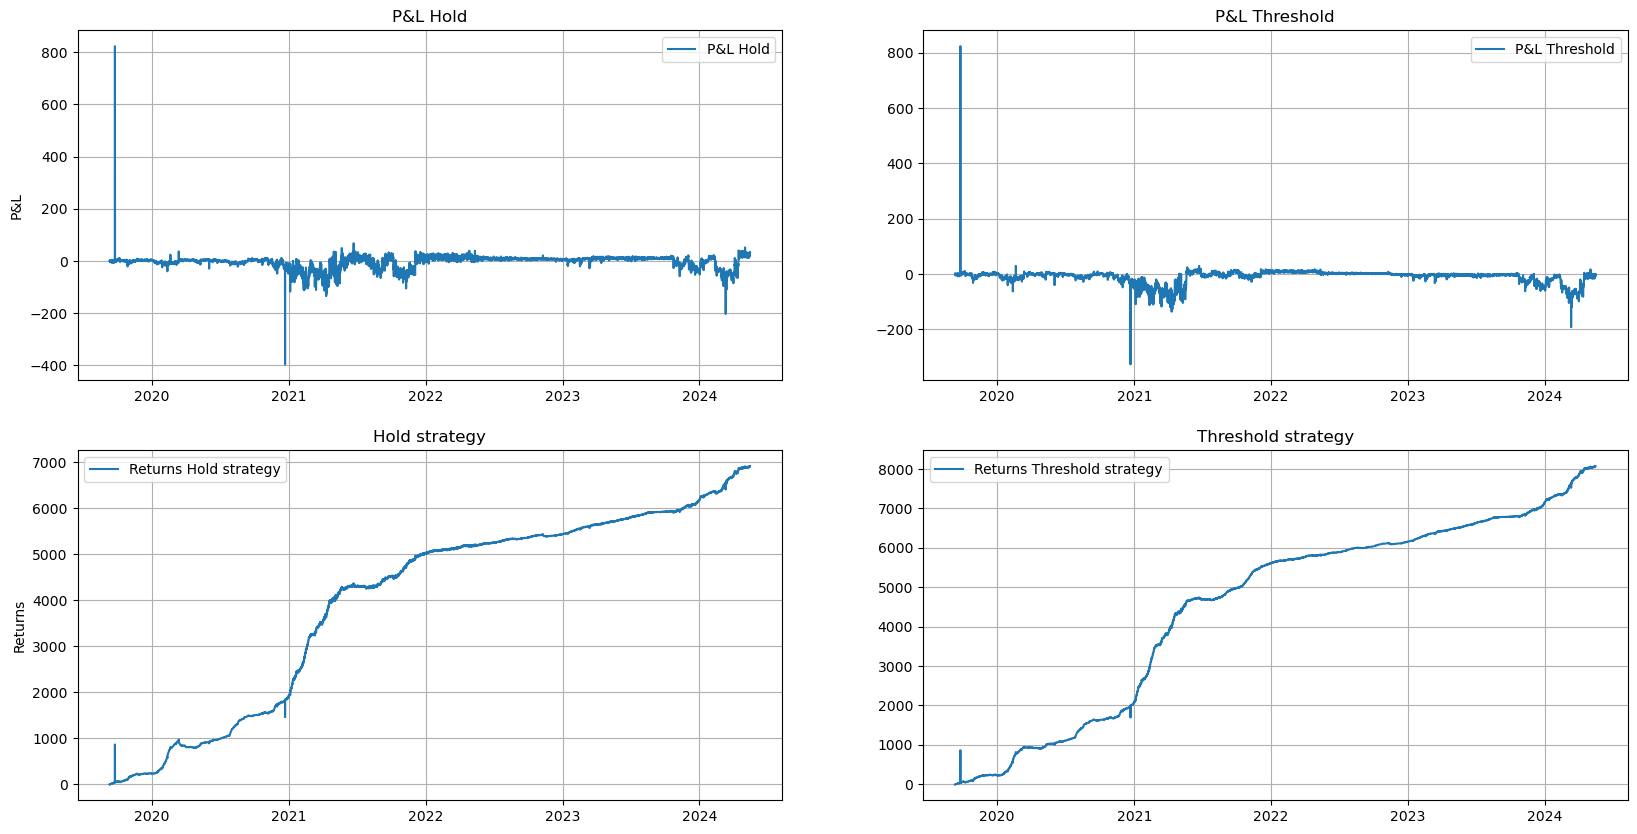

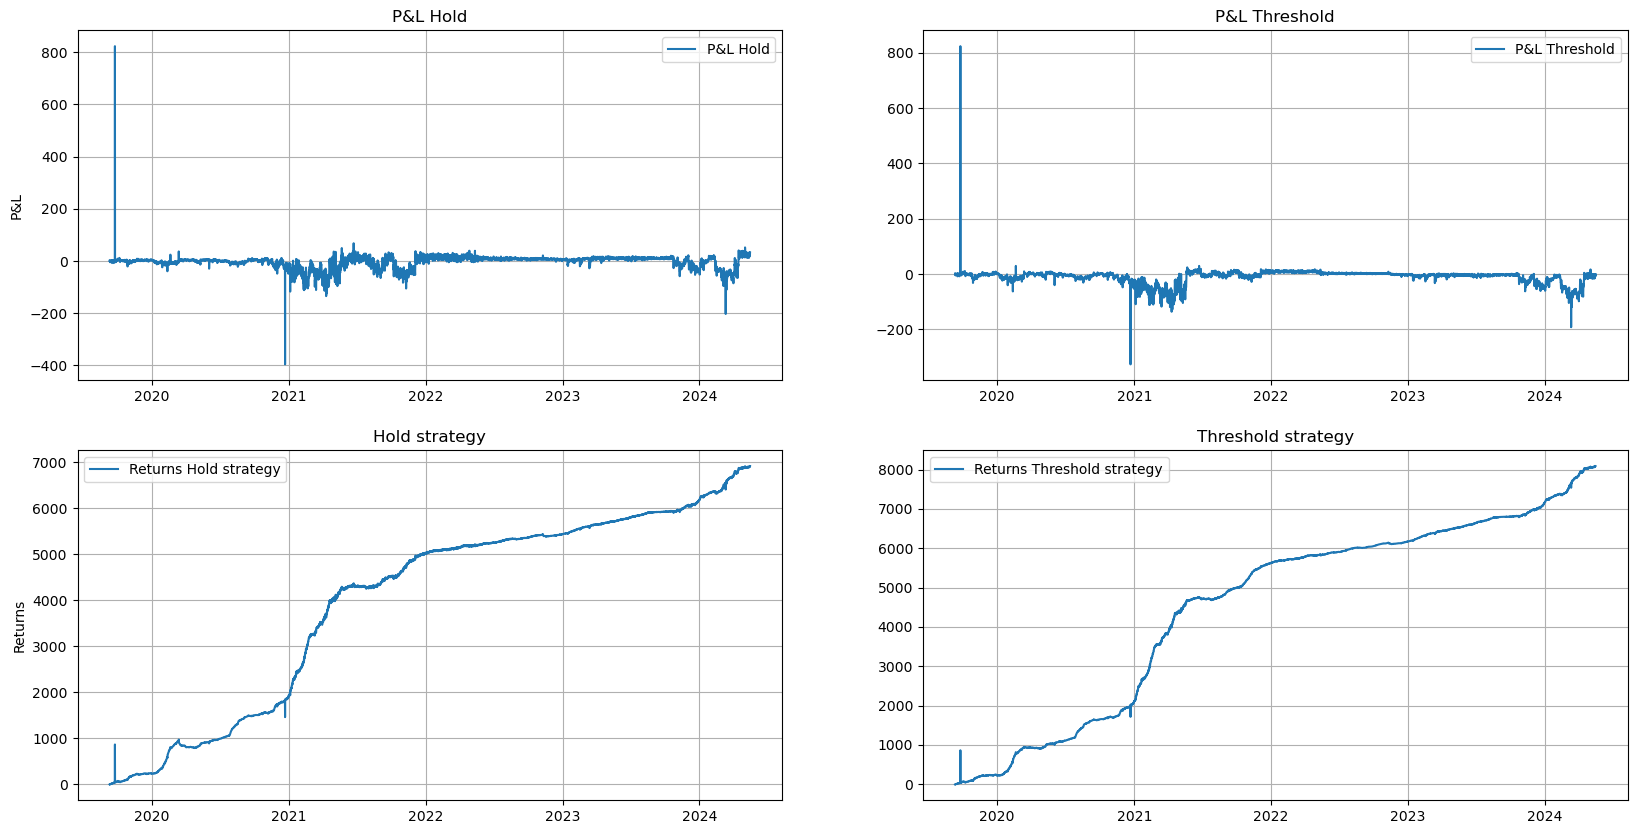

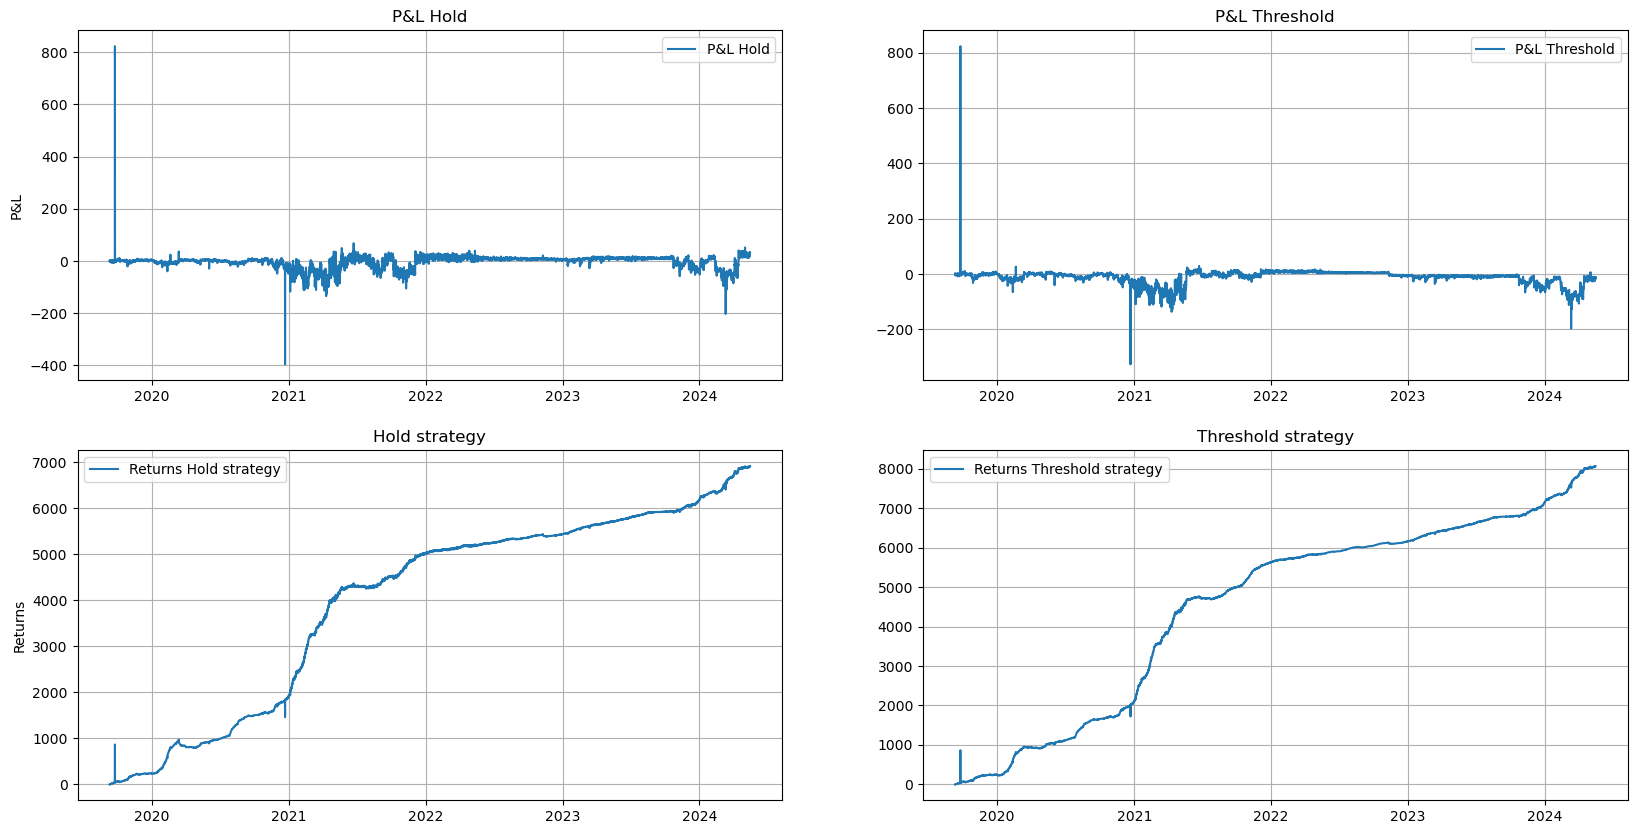

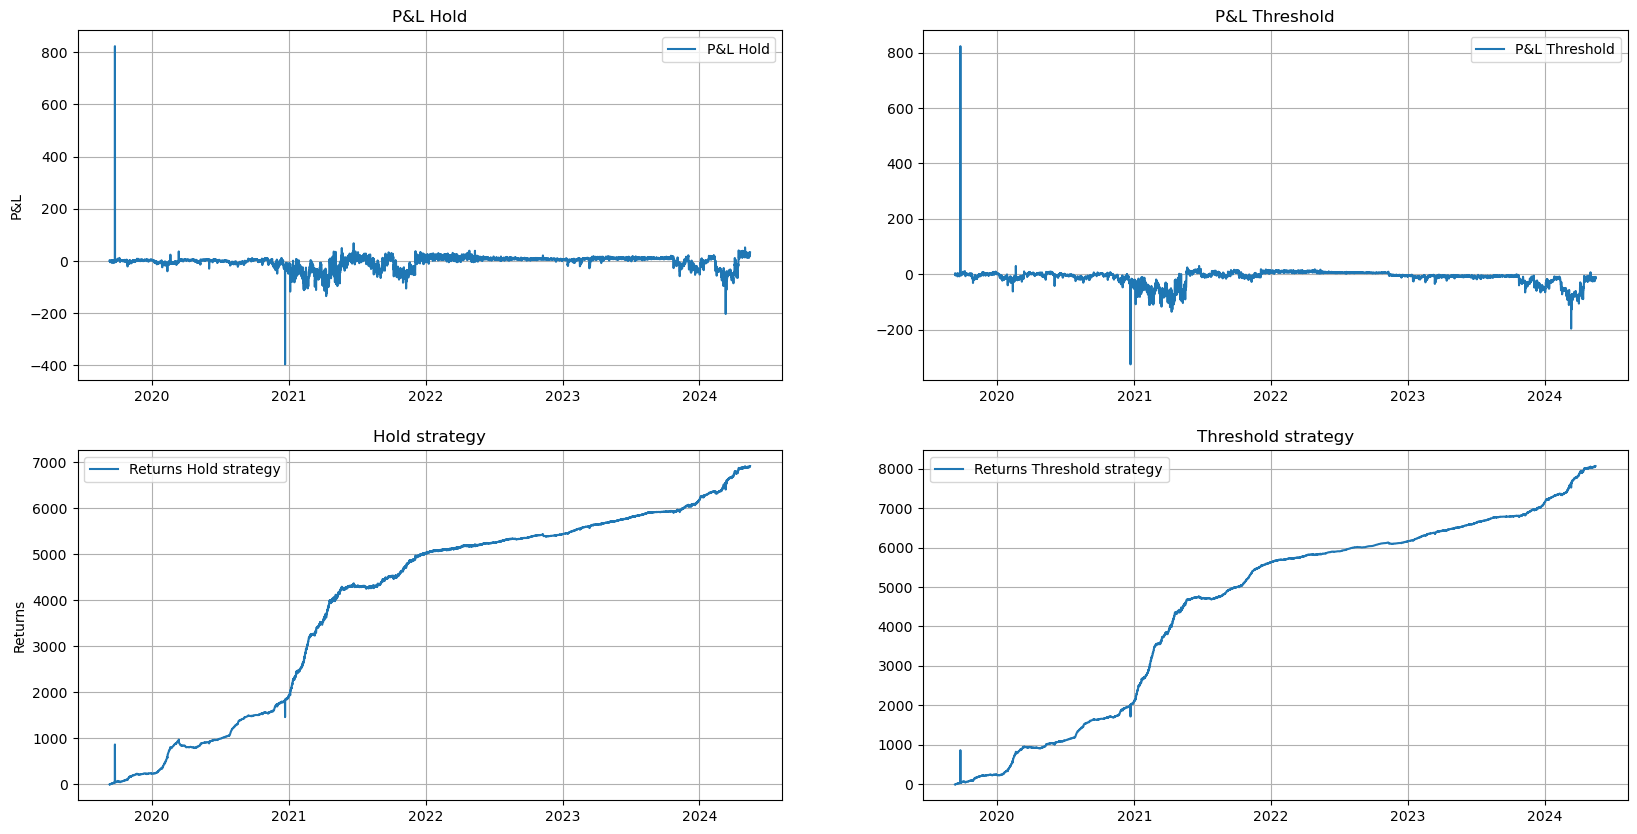

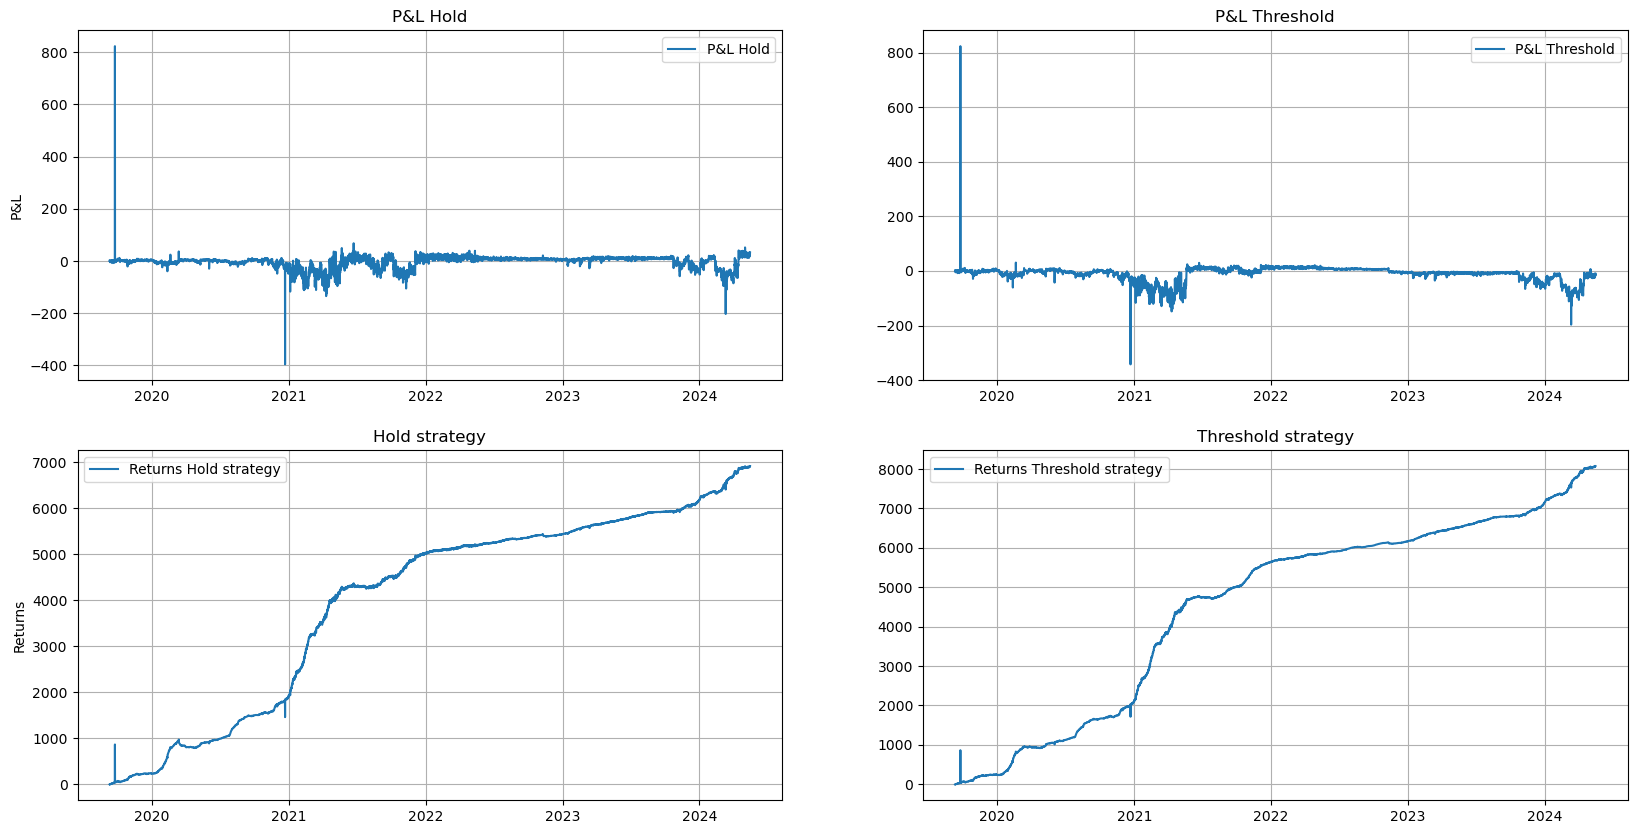

In [91]:
for data_threshold in data_thresholds:
    plot_data_side_by_side(data_hold, data_threshold)

In [92]:
data_hold.describe()

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,3979.992205,-3.658253
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2118.472889,26.047711
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-396.399202
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1564.521159,-8.506322
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5048.994958,3.660401
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,5601.320913,9.357027
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,6908.696313,823.137785


In [93]:
for data_threshold in data_thresholds:
    display(data_threshold.describe())
    print("\n")  # Pour ajouter une ligne vide entre chaque description

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4209.703503,-7.868237
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2203.668324,18.345408
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-249.907920
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1673.431055,-12.281377
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5562.240466,-2.192605
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,5805.396250,0.000000
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,7215.021127,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4369.013753,-9.528590
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2347.007482,22.558241
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.274204
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1684.063146,-12.758975
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5605.151831,-2.205787
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6111.096974,0.275220
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,7802.533373,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4478.532712,-8.645106
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2426.659004,22.686017
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.518595
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1708.235277,-10.313839
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5653.561166,-2.319151
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6323.966685,0.381183
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8064.293746,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4498.024637,-9.699428
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2448.287844,22.948026
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.532652
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1696.181399,-11.244925
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5656.234222,-3.387872
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6378.454339,0.000000
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8119.207742,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4499.603897,-10.488524
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2446.671306,25.647412
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.452128
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1697.432116,-12.506480
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5659.906256,-3.110299
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6386.858824,1.670518
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8087.906308,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4492.174616,-10.230447
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2443.241569,25.494411
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.166095
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1697.191606,-12.224645
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5652.097937,-2.901731
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6375.380436,1.753719
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8073.166222,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4504.519469,-10.335957
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2447.181657,25.484697
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.063420
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1716.723184,-12.588300
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5666.758323,-3.023830
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6389.622554,1.784599
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8086.426526,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4502.832252,-11.770424
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2441.424399,26.401333
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-325.985419
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1722.267172,-15.386788
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5671.517188,-5.670040
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6378.257172,3.644183
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8066.569011,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4499.542004,-11.700083
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2439.723999,26.375132
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-325.852983
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1719.663619,-14.992638
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5667.309202,-5.705552
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6373.762064,3.631365
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8061.388005,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4509.753233,-11.154748
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2441.353214,28.444420
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-342.257087
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1730.531596,-14.736728
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5681.222294,-5.059090
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6383.441718,5.859240
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8070.200094,823.137785


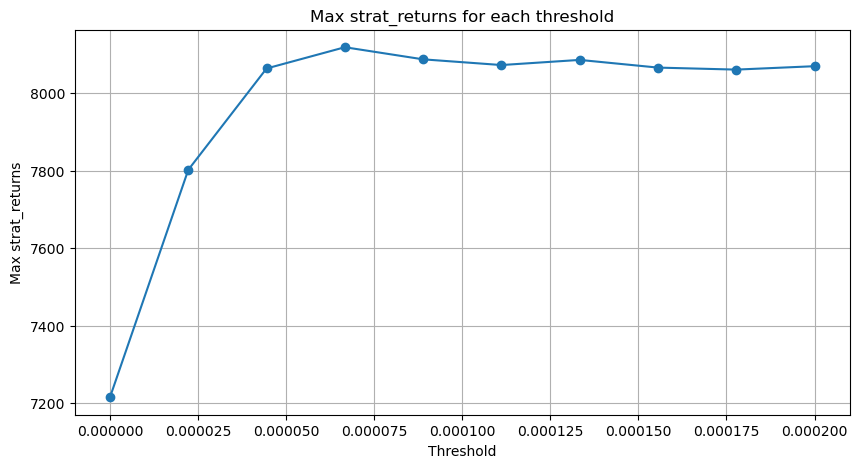

In [94]:
# Plot the max strat_returns for each threshold
max_strat_returns = [data_threshold['strat_returns'].max() for data_threshold in data_thresholds]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, max_strat_returns, marker='o')
plt.title('Max strat_returns for each threshold')
plt.xlabel('Threshold')
plt.ylabel('Max strat_returns')
plt.grid(True)
plt.show()